In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9697.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_10087.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9618.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9614.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9862.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9838.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9851.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9691.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_10011.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9785.jpg
/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test/benign/melanoma_9882.jpg
/kaggle/input/skin-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel
import timm

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Dataset Paths
train_data_path = '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/train'
test_data_path = '/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset/test'

# Load Data
train_dataset = datasets.ImageFolder(root=train_data_path, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=data_transforms['test'])

# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

****1.ResNet - VIT****

In [8]:
# Vision Transformer Model with Self-Attention
class ViTSelfAttention(nn.Module):
    def __init__(self, pretrained_model="google/vit-base-patch16-224", num_classes=512):
        super(ViTSelfAttention, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.fc = nn.Linear(self.vit.config.hidden_size, num_classes)  # Reduce to 512 features

    def forward(self, x):
        outputs = self.vit(x)
        cls_token = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_token)

# Hybrid Model: ResNet + ViT Self-Attention
class ResNetWithViT(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetWithViT, self).__init__()
        self.resnet = timm.create_model("resnet50", pretrained=True, num_classes=512)
        self.vit = ViTSelfAttention()
        self.fc = nn.Linear(1024, num_classes)  # Adjusted feature size

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        return torch.sigmoid(self.fc(combined_features))

In [9]:
# Initialize Model
model = ResNetWithViT().to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print("Training complete!")

# Train Model
train_model(model, train_loader, criterion, optimizer)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Loss: 0.5626
Epoch [2/10], Loss: 0.5525
Epoch [3/10], Loss: 0.5413
Epoch [4/10], Loss: 0.5391
Epoch [5/10], Loss: 0.5397
Epoch [6/10], Loss: 0.5368
Epoch [7/10], Loss: 0.5362
Epoch [8/10], Loss: 0.5344
Epoch [9/10], Loss: 0.5331
Epoch [10/10], Loss: 0.5322
Training complete!


In [10]:
# Testing Function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate Model
test_model(model, test_loader)

# Save Model
torch.save(model.state_dict(), "ResNet_ViT_SkinCancer.pth")

Test Accuracy: 82.40%


In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Dataset directories
BASE_DIR = "/kaggle/input/skin-cancer-melanoma/melanoma_cancer_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [27]:
# Rescaling only for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load Testing Data
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR, 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# Self-Attention Mechanism
class SelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttention, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.norm = layers.LayerNormalization()
        self.add = layers.Add()
    
    def call(self, inputs):
        attn_output = self.mha(inputs, inputs)
        return self.add([inputs, self.norm(attn_output)])

****DenseNet121+ViT****

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global pooling
x = GlobalAveragePooling2D()(base_model.output)

# Dense layer
x = Dense(256, activation='relu')(x)

# Reshape for Self-Attention: Convert (batch_size, 256) → (batch_size, 1, 256)
x = Reshape((1, 256))(x)

# Multi-Head Self-Attention
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

# Normalize
x = LayerNormalization()(x)

# Flatten back to 2D
x = tf.keras.layers.Flatten()(x)

# Output layer
x = Dense(1, activation='sigmoid')(x)

# Create the model
densenet_sa_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
densenet_sa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
densenet_sa_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,563,841 (28.85 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

****DENSENET121****

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global pooling
x = GlobalAveragePooling2D()(base_model.output)

# Dense layer
x = Dense(256, activation='relu')(x)

# Reshape for Self-Attention: Convert (batch_size, 256) → (batch_size, 1, 256)
x = Reshape((1, 256))(x)

# Multi-Head Self-Attention
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

# Normalize
x = LayerNormalization()(x)

# Flatten back to 2D
x = tf.keras.layers.Flatten()(x)

# Output layer
x = Dense(1, activation='sigmoid')(x)

# Create the DenseNet + Self-Attention model
densenet_sa_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
densenet_sa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Store all models in a list
models = [densenet_sa_model]  # Add other models if needed (e.g., CNN, ViT, etc.)

In [43]:
# Training and Evaluation Function
def train_and_evaluate(model, train_gen, test_gen, epochs=20):
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen)
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Get predictions
    y_pred_probs = model.predict(test_gen)  # Get probabilities
    y_pred_binary = (y_pred_probs > 0.5).astype(int)  # Convert to binary predictions

    # Confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred_binary)

    # Plotting confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Melanoma', 'Melanoma'], yticklabels=['No Melanoma', 'Melanoma'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

     # ROC curve and AUC
    fpr, tpr, _ = roc_curve(test_gen.classes, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

Training Model 1...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 397s 826ms/step - accuracy: 0.8788 - loss: 0.2861 - val_accuracy: 0.8980 - val_loss: 0.2309
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 127s 412ms/step - accuracy: 0.9296 - loss: 0.1822 - val_accuracy: 0.9160 - val_loss: 0.1995
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 129s 422ms/step - accuracy: 0.9323 - loss: 0.1721 - val_accuracy: 0.9260 - val_loss: 0.1828
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 128s 416ms/step - accuracy: 0.9391 - loss: 0.1442 - val_accuracy: 0.9100 - val_loss: 0.2048
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 131s 425ms/step - accuracy: 0.9451 - loss: 0.1322 - val_accuracy: 0.9180 - val_loss: 0.2100
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 130s 422ms/step - accuracy: 0.9489 - loss: 0.1220 - val_accuracy: 0.9070 - val_loss: 0.2602
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 130s 420ms/step - accuracy: 0.9558 - loss: 0.1148 - val_accuracy: 0.9200 - val_loss: 0.1919
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 131s 423ms/step - accuracy: 0.9603 - loss: 0.10

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step


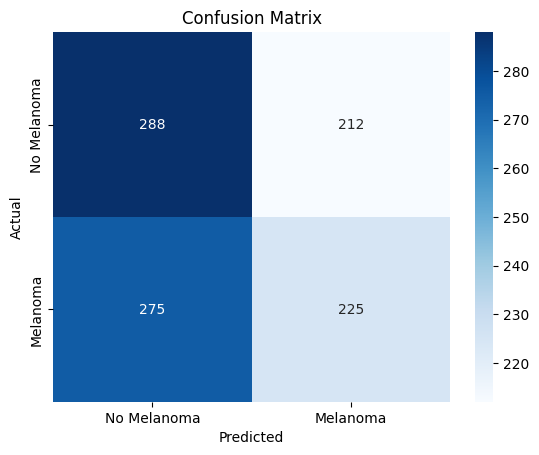

AUC: 0.5144


In [44]:
# ✅ Train and evaluate each model
for i, model in enumerate(models):
    print(f"Training Model {i+1}...")
    train_and_evaluate(model, train_generator, test_generator, epochs=20)

****GRU+ViT****

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GRU, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention

# ✅ Optimized Functional API Model
inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# ✅ Corrected Model (GRU Input Reshaped Properly)
x = Flatten()(x)  # Flatten feature map
x = Reshape((1, -1))(x)  # Reshape to (batch_size, timesteps=1, features)

x = GRU(64, return_sequences=True)(x)  # GRU Layer (Now gets 3D input)

# ✅ Multi-Head Attention (Optimized)
attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = LayerNormalization()(attn_output)

x = Flatten()(x)  # Flatten for Dense Layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification


# ✅ Create the Model
optimized_gru_model = Model(inputs, outputs)

# ✅ Compile the Model
optimized_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Model Summary
optimized_gru_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 222, 222, 32)   │            896 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 111, 111, 32)   │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 109, 109, 64)   │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 54, 54, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 186624)         │              0 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 186624)      │              0 │ flatten_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ (None, 1, 64)          │     35,844,480 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 1, 64)          │         33,216 │ gru_3[0][0],           │
│ (MultiHeadAttention)      │                        │                │ gru_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 1, 64)          │            128 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 64)             │              0 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │          4,160 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1)              │             65 │ dropout_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 35,901,441 (136.95 MB)

 Trainable params: 35,901,441 (136.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8835 - loss: 0.3709 - val_accuracy: 0.9057 - val_loss: 0.3132
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9038 - loss: 0.3391 - val_accuracy: 0.9057 - val_loss: 0.3146
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9064 - loss: 0.3302 - val_accuracy: 0.9057 - val_loss: 0.3125
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9069 - loss: 0.3262 - val_accuracy: 0.9057 - val_loss: 0.3147
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9045 - loss: 0.3321 - val_accuracy: 0.9057 - val_loss: 0.3126
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9042 - loss: 0.3312 - val_accuracy: 0.9057 - val_loss: 0.3128
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9068 - loss: 0.3249 - val_accuracy: 0.9057 - val_loss: 0.3129
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9052 - loss: 0.3250 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step


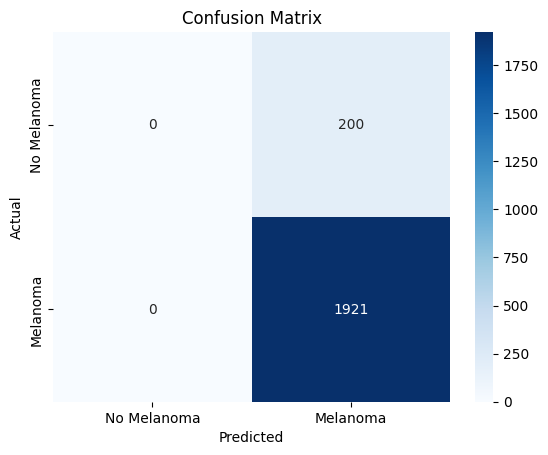

              precision    recall  f1-score   support

 No Melanoma       0.00      0.00      0.00       200
    Melanoma       0.91      1.00      0.95      1921

    accuracy                           0.91      2121
   macro avg       0.45      0.50      0.48      2121
weighted avg       0.82      0.91      0.86      2121

AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


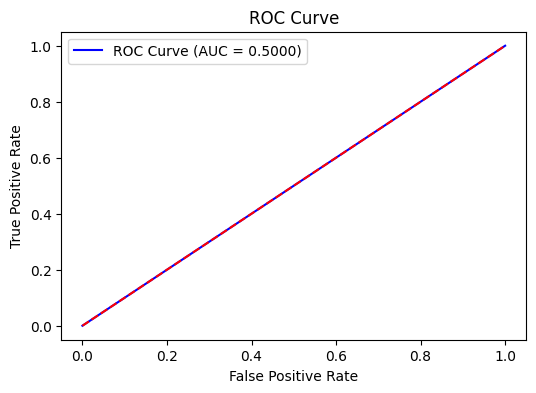

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Training & Evaluation Function
def train_and_evaluate(model, train_gen, test_gen, epochs=10):
    # Train the model
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Predictions
    y_true = test_gen.classes  # True labels
    y_pred_probs = model.predict(test_gen)  # Probability predictions
    y_pred_binary = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary predictions

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Melanoma', 'Melanoma'], yticklabels=['No Melanoma', 'Melanoma'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ✅ Classification Report (Precision, Recall, F1-Score)
    report = classification_report(y_true, y_pred_binary, target_names=['No Melanoma', 'Melanoma'])
    print(report)

    # ✅ ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ✅ Train & Evaluate Optimized Model
train_and_evaluate(optimized_gru_model, train_generator, test_generator, epochs=10)